# Sandbox: GraphConvAE

This notebook can be used for familiarization with the pytorch geometric package to train a GraphConvAE using a PPI as input.

---

## 0. Environmental setup

In [158]:
import pandas as pd
import networkx as nx
import numpy as np
import sys
import os
import random
import matplotlib.pyplot as plt
import community as community_louvain
from torch_geometric.data import Data
from torch import LongTensor, FloatTensor
from torch_geometric.utils import train_test_split_edges
import torch_geometric.transforms as T
import torch
from tqdm import tqdm
from torch_geometric.datasets import PPI, LastFMAsia

sys.path.append("../../../")

from src.models.ae import GraphConvAE
from src.utils.basic.visualization import plot_train_val_hist

seed = 1234
np.random.seed(seed)
random.seed(seed)
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

---

## 1. Simple example

In the first simple example we will generate a simple graph containing 100 nodes and aim to learn an embedding after randomly assigning one feature to each of these nodes.

### 1.1. Graph setup

The generated graph is seen below colored using the Louvain community detection algorithm

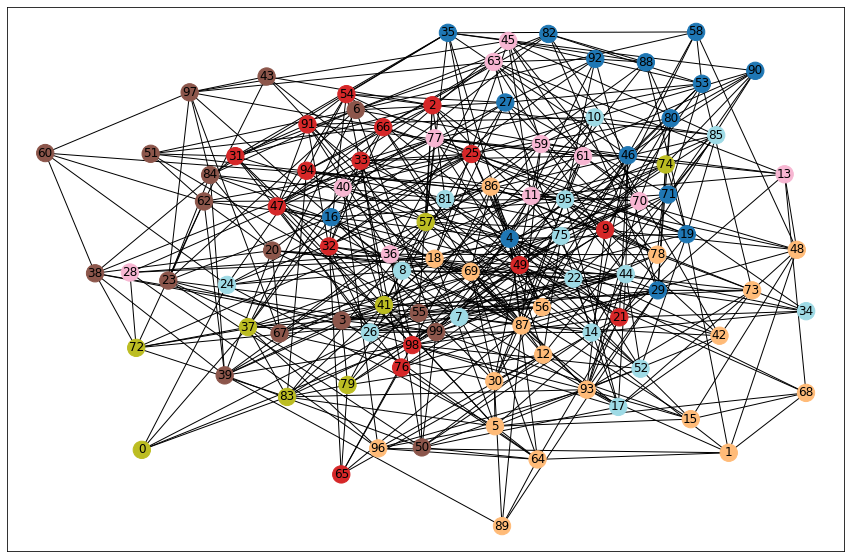

<IPython.core.display.Javascript object>

In [2]:
n = 100
p = 0.1

graph = nx.generators.random_graphs.fast_gnp_random_graph(n, p, seed=1234)
for n in graph.nodes():
    graph.nodes[n]["x"] = np.round(np.random.uniform(), decimals=4)
node_features = nx.get_node_attributes(graph, "x")

partition = community_louvain.best_partition(graph)

pos = nx.spring_layout(graph, seed=seed)
plt.figure(figsize=[15, 10])
# nx.draw_networkx_edge_labels(graph,pos=pos,edge_labels=labels)
nx.draw_networkx(graph, pos=pos, node_color=list(partition.values()), cmap="tab20")

---

### 1.2 Data setup

Now we will derive the required quantities to describe the graph in form of torch.Tensors to make it applicable input for the pytorch_geometric package.

In [3]:
edge_idx = np.array(graph.edges()).transpose()
edge_idx = LongTensor(edge_idx)

node_feat = FloatTensor(list(node_features.values())).unsqueeze(dim=1)

<IPython.core.display.Javascript object>

In [4]:
data = Data(x=node_feat, edge_index=edge_idx, edge_attr=None, pos=None)
data

Data(edge_index=[2, 489], x=[100, 1])

<IPython.core.display.Javascript object>

In [159]:
data = LastFMAsia(root="/home/paysan_d/Downloads", transform=T.NormalizeFeatures())[0]
data

Data(edge_index=[2, 342004], x=[22470, 128], y=[22470])

<IPython.core.display.Javascript object>

Next, we split the data into a training, validation and test set (0.7/0.1/0.2) as a size.

In [160]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = T.Compose([T.NormalizeFeatures()])
data = transform(data).to(device)
data_split = train_test_split_edges(data, val_ratio=0.1, test_ratio=0.2)
data_split

Data(test_neg_edge_index=[2, 34164], test_pos_edge_index=[2, 34164], train_neg_adj_mask=[22470, 22470], train_pos_edge_index=[2, 239154], val_neg_edge_index=[2, 17082], val_pos_edge_index=[2, 17082], x=[22470, 128], y=[22470])

<IPython.core.display.Javascript object>

Let us construct 3 individual data sets for each portion to make the downstream analyses upwards compatible.

In [161]:
data_train = Data(x=data_split.x, edge_index=data_split.train_pos_edge_index)
data_train.edge_index = data_train.edge_index

data_val = Data(x=data_split.x, edge_index=data_split.val_pos_edge_index)
data_val.neg_edge_index = data.val_neg_edge_index

data_test = Data(x=data_split.x, edge_index=data_split.test_pos_edge_index)
data_test.neg_edge_index = data.test_neg_edge_index

data_dict = {"train": data_train, "val": data_val, "test": data_test}

<IPython.core.display.Javascript object>

---

### 1.3. Model setup

Next, we set up our Graph-convolutional Autoencoder as defined by Kipf & Welling (2016).

In [162]:
input_channels = data.num_features
hidden_dims = 256
latent_dim = 128

model = GraphConvAE(
    input_channels=input_channels, hidden_dims=hidden_dims, latent_dim=latent_dim
)
model

GraphConvAE(
  (encoder): GCNEncoder(
    (gcn1): GCNConv(128, 256)
    (relu): ReLU()
    (gcn2): GCNConv(256, 128)
  )
  (model): GAE(
    (encoder): GCNEncoder(
      (gcn1): GCNConv(128, 256)
      (relu): ReLU()
      (gcn2): GCNConv(256, 128)
    )
    (decoder): InnerProductDecoder()
  )
)

<IPython.core.display.Javascript object>

The GAE consists of two-layer graph-convolutional encoder that maps the node embedding from 1-16-8 dimensions. That is the latent space will be given by a euclidean 8 dimensional space. We apply a ReLU activation for nonlinearity after the first GCNConv layer.
The decoder is simply an innerproduct decoder that takes the sigmoid of the inner product of the latent embeddings for two nodes in order to compute a probabilistic adjacency matrix.

Next, we push everything to the GPU and define the Adam optimizer that we will use to train the model.

In [163]:
model = model.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>

---

### 1.4. Model training

In [164]:
def process_single_epoch(model, data, mode, optimizer):
    if mode == "train":
        model.train()
        optimizer.zero_grad()
        latents = model(data.x, data.edge_index)["latents"]
        # Negative edges created via negative sampling
        loss = model.loss_function(latents, data.edge_index)
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        latents = model(data.x, data.edge_index)["latents"]
        loss = model.loss_function(latents, data.edge_index)

    return loss.item()


def test_gae(model, data):
    model.eval()
    latents = model.encode(data.x, data.edge_index)
    auc, ap = model.test(latents, data.edge_index, data.neg_edge_index)
    return auc, ap


def train_gae(model, data_dict, n_epochs=500, early_stopping=500):
    best_val_loss = np.infty
    loss_hist = {"train": [], "val": []}
    es_counter = 0

    best_model_weights = None
    best_epoch = -1

    for i in range(n_epochs):
        print("---" * 20)
        if es_counter < early_stopping:
            for mode in ["train", "val"]:
                loss = process_single_epoch(model, data_dict[mode], mode, optimizer)
                print("{} loss:".format(mode.upper()), loss)
                loss_hist[mode].append(loss)

                if mode == "val":
                    if loss < best_val_loss:
                        es_counter = 0
                        best_val_loss = loss
                        best_model_weights = model.state_dict()
                        best_epoch = i
                    else:
                        es_counter += 1
                    auc, ap = test_gae(model, data_dict[mode])
                    print("VAL AUC: {} \t AP: {}".format(auc, ap))
        else:
            print("Training stopped after {} epochs".format(i + 1))
            print("Best model found at epoch {}".format(best_epoch))
            break

    print("---" * 20)
    model.load_state_dict(best_model_weights)
    auc, ap = test_gae(model, data_dict["test"])
    print("TEST AUC: {} \t AP: {}".format(auc, ap))
    return model, loss_hist

<IPython.core.display.Javascript object>

In [165]:
model, loss_hist = train_gae(model, data_dict, n_epochs=1000)
plot_train_val_hist(
    loss_hist["train"],
    loss_hist["val"],
    output_dir="/home/paysan_d/Desktop/",
    y_label="BCE",
)

------------------------------------------------------------
TRAIN loss: 2.41567063331604
VAL loss: 2.3209567070007324
VAL AUC: 0.7953482890938083 	 AP: 0.832332993160775
------------------------------------------------------------
TRAIN loss: 2.321843147277832
VAL loss: 2.278520107269287
VAL AUC: 0.797819814247224 	 AP: 0.8347340674051564
------------------------------------------------------------
TRAIN loss: 2.2380309104919434
VAL loss: 2.171208620071411
VAL AUC: 0.8003581157965007 	 AP: 0.8372564294884917
------------------------------------------------------------
TRAIN loss: 2.168253183364868
VAL loss: 2.092118263244629
VAL AUC: 0.802961994268272 	 AP: 0.8396843288150497
------------------------------------------------------------
TRAIN loss: 2.085584878921509
VAL loss: 2.048582077026367
VAL AUC: 0.8056336361311316 	 AP: 0.8422268114980891
------------------------------------------------------------
TRAIN loss: 2.0095534324645996
VAL loss: 1.9591760635375977
VAL AUC: 0.8083728426

TRAIN loss: 0.9997584223747253
VAL loss: 1.0173875093460083
VAL AUC: 0.9226021132582232 	 AP: 0.9316669739880352
------------------------------------------------------------
TRAIN loss: 0.9924396276473999
VAL loss: 1.0172202587127686
VAL AUC: 0.9237062798983301 	 AP: 0.9324788260077308
------------------------------------------------------------
TRAIN loss: 0.9916117787361145
VAL loss: 1.0168125629425049
VAL AUC: 0.9247357930296229 	 AP: 0.9333012533263406
------------------------------------------------------------
TRAIN loss: 0.9847182035446167
VAL loss: 1.0086745023727417
VAL AUC: 0.9256966311700687 	 AP: 0.9340224965723598
------------------------------------------------------------
TRAIN loss: 0.9817838072776794
VAL loss: 1.008742332458496
VAL AUC: 0.9265985049133376 	 AP: 0.9347040619146787
------------------------------------------------------------
TRAIN loss: 0.9767851233482361
VAL loss: 1.0031800270080566
VAL AUC: 0.9274413217286274 	 AP: 0.935346415438316
-------------------

TRAIN loss: 0.9134790301322937
VAL loss: 0.9397608637809753
VAL AUC: 0.9407795478166356 	 AP: 0.9464767997867225
------------------------------------------------------------
TRAIN loss: 0.9106594324111938
VAL loss: 0.9417616128921509
VAL AUC: 0.9409134895804353 	 AP: 0.9465968842930743
------------------------------------------------------------
TRAIN loss: 0.9092535972595215
VAL loss: 0.9368545413017273
VAL AUC: 0.9410446262900902 	 AP: 0.9467134694828834
------------------------------------------------------------
TRAIN loss: 0.9091861844062805
VAL loss: 0.9377313256263733
VAL AUC: 0.9411710439288135 	 AP: 0.9468263379907829
------------------------------------------------------------
TRAIN loss: 0.9078551530838013
VAL loss: 0.9404388666152954
VAL AUC: 0.9412931674528837 	 AP: 0.946936305721141
------------------------------------------------------------
TRAIN loss: 0.9063997268676758
VAL loss: 0.9384570121765137
VAL AUC: 0.9414141960291235 	 AP: 0.9470455672524463
------------------

TRAIN loss: 0.8879234194755554
VAL loss: 0.9176046848297119
VAL AUC: 0.9456734111477629 	 AP: 0.9508025054646824
------------------------------------------------------------
TRAIN loss: 0.8883490562438965
VAL loss: 0.9138439893722534
VAL AUC: 0.9457581590817248 	 AP: 0.9508752825784806
------------------------------------------------------------
TRAIN loss: 0.8879384994506836
VAL loss: 0.9202209711074829
VAL AUC: 0.9458402476118793 	 AP: 0.9509460807693736
------------------------------------------------------------
TRAIN loss: 0.8872318267822266
VAL loss: 0.9202934503555298
VAL AUC: 0.9459219334616893 	 AP: 0.9510167569114075
------------------------------------------------------------
TRAIN loss: 0.8885491490364075
VAL loss: 0.9146230220794678
VAL AUC: 0.9460028327996775 	 AP: 0.9510868553547653
------------------------------------------------------------
TRAIN loss: 0.8873911499977112
VAL loss: 0.9157814383506775
VAL AUC: 0.9460832095099841 	 AP: 0.9511559180092007
-----------------

TRAIN loss: 0.8765671253204346
VAL loss: 0.9116290211677551
VAL AUC: 0.9491091552429852 	 AP: 0.9537536250853987
------------------------------------------------------------
TRAIN loss: 0.8788317441940308
VAL loss: 0.9061011075973511
VAL AUC: 0.9491727513208907 	 AP: 0.953807722346354
------------------------------------------------------------
TRAIN loss: 0.8787471652030945
VAL loss: 0.9068130850791931
VAL AUC: 0.9492359909838535 	 AP: 0.9538615160673933
------------------------------------------------------------
TRAIN loss: 0.8791279792785645
VAL loss: 0.9061654210090637
VAL AUC: 0.9492976147848375 	 AP: 0.9539260773956225
------------------------------------------------------------
TRAIN loss: 0.8777191638946533
VAL loss: 0.9095482230186462
VAL AUC: 0.9493573211419684 	 AP: 0.9539772666579431
------------------------------------------------------------
TRAIN loss: 0.8775779604911804
VAL loss: 0.9086275696754456
VAL AUC: 0.9494161930083423 	 AP: 0.9540278083625728
------------------

TRAIN loss: 0.8693735599517822
VAL loss: 0.8914214372634888
VAL AUC: 0.9519290417327766 	 AP: 0.9561732954928012
------------------------------------------------------------
TRAIN loss: 0.8672066926956177
VAL loss: 0.8974612951278687
VAL AUC: 0.9519811451422953 	 AP: 0.9562181499497928
------------------------------------------------------------
TRAIN loss: 0.8698590397834778
VAL loss: 0.8986698389053345
VAL AUC: 0.9520357588782173 	 AP: 0.9562645640804981
------------------------------------------------------------
TRAIN loss: 0.8676994442939758
VAL loss: 0.9032548666000366
VAL AUC: 0.9520908027110182 	 AP: 0.9563170192163993
------------------------------------------------------------
TRAIN loss: 0.867872953414917
VAL loss: 0.899115264415741
VAL AUC: 0.9521448544079912 	 AP: 0.956362488363568
------------------------------------------------------------
TRAIN loss: 0.8684590458869934
VAL loss: 0.9031845927238464
VAL AUC: 0.952198801579428 	 AP: 0.9564081295024264
---------------------

TRAIN loss: 0.8629165887832642
VAL loss: 0.8910738229751587
VAL AUC: 0.9543276097754256 	 AP: 0.9582278961756965
------------------------------------------------------------
TRAIN loss: 0.8625015616416931
VAL loss: 0.8913198709487915
VAL AUC: 0.9543704840941536 	 AP: 0.9582680698580504
------------------------------------------------------------
TRAIN loss: 0.8663846254348755
VAL loss: 0.8953903913497925
VAL AUC: 0.9544136308646898 	 AP: 0.9583052504973406
------------------------------------------------------------
TRAIN loss: 0.8641495108604431
VAL loss: 0.896945595741272
VAL AUC: 0.9544556244272602 	 AP: 0.9583417162634968
------------------------------------------------------------
TRAIN loss: 0.863506555557251
VAL loss: 0.8924180865287781
VAL AUC: 0.9544970353884807 	 AP: 0.9583779526274816
------------------------------------------------------------
TRAIN loss: 0.8612484931945801
VAL loss: 0.8926243185997009
VAL AUC: 0.9545366043013169 	 AP: 0.9584131687098574
-------------------

TRAIN loss: 0.8592981100082397
VAL loss: 0.890592634677887
VAL AUC: 0.9561817042997667 	 AP: 0.9598419754970233
------------------------------------------------------------
TRAIN loss: 0.8596141338348389
VAL loss: 0.8962209820747375
VAL AUC: 0.9562193797582166 	 AP: 0.9598737192862277
------------------------------------------------------------
TRAIN loss: 0.8574997782707214
VAL loss: 0.8924816846847534
VAL AUC: 0.9562557083794291 	 AP: 0.9599031899779543
------------------------------------------------------------
TRAIN loss: 0.85633784532547
VAL loss: 0.8900967836380005
VAL AUC: 0.9562886202150797 	 AP: 0.9599317472348594
------------------------------------------------------------
TRAIN loss: 0.8557837009429932
VAL loss: 0.8890944123268127
VAL AUC: 0.9563208260749775 	 AP: 0.9599615773055858
------------------------------------------------------------
TRAIN loss: 0.8598116040229797
VAL loss: 0.8950871825218201
VAL AUC: 0.9563481466512053 	 AP: 0.959986629072825
---------------------

TRAIN loss: 0.8542474508285522
VAL loss: 0.881648600101471
VAL AUC: 0.9576508878207132 	 AP: 0.9611264803381371
------------------------------------------------------------
TRAIN loss: 0.8537734746932983
VAL loss: 0.885667085647583
VAL AUC: 0.9576755558472675 	 AP: 0.9611489591813158
------------------------------------------------------------
TRAIN loss: 0.8532536029815674
VAL loss: 0.8864537477493286
VAL AUC: 0.9576975147775462 	 AP: 0.9611696208106615
------------------------------------------------------------
TRAIN loss: 0.8552781939506531
VAL loss: 0.8800885081291199
VAL AUC: 0.9577179041112478 	 AP: 0.9611894317689798
------------------------------------------------------------
TRAIN loss: 0.8552045822143555
VAL loss: 0.8801334500312805
VAL AUC: 0.9577416451162428 	 AP: 0.9612104864510139
------------------------------------------------------------
TRAIN loss: 0.8548849821090698
VAL loss: 0.8869631886482239
VAL AUC: 0.9577660561127898 	 AP: 0.9612307613177757
-------------------

TRAIN loss: 0.8484513163566589
VAL loss: 0.884884238243103
VAL AUC: 0.9588665455102607 	 AP: 0.962174281743382
------------------------------------------------------------
TRAIN loss: 0.8501800298690796
VAL loss: 0.8875572681427002
VAL AUC: 0.9588904013219925 	 AP: 0.9621936326023556
------------------------------------------------------------
TRAIN loss: 0.8516407012939453
VAL loss: 0.8775646090507507
VAL AUC: 0.9589170861773361 	 AP: 0.9622157344236036
------------------------------------------------------------
TRAIN loss: 0.8500973582267761
VAL loss: 0.8854509592056274
VAL AUC: 0.9589421020511667 	 AP: 0.9622352368722817
------------------------------------------------------------
TRAIN loss: 0.8509635329246521
VAL loss: 0.8806592226028442
VAL AUC: 0.9589673304031363 	 AP: 0.9622573059751682
------------------------------------------------------------
TRAIN loss: 0.8502370119094849
VAL loss: 0.8842153549194336
VAL AUC: 0.9589922006266296 	 AP: 0.9622790672944891
-------------------

TRAIN loss: 0.8469074964523315
VAL loss: 0.8814895153045654
VAL AUC: 0.9599494249251743 	 AP: 0.9631147510711431
------------------------------------------------------------
TRAIN loss: 0.847633421421051
VAL loss: 0.8728170990943909
VAL AUC: 0.9599768620216724 	 AP: 0.9631369719727947
------------------------------------------------------------
TRAIN loss: 0.8468495607376099
VAL loss: 0.8808286786079407
VAL AUC: 0.9600061034688209 	 AP: 0.9631598144500056
------------------------------------------------------------
TRAIN loss: 0.8459736704826355
VAL loss: 0.8804080486297607
VAL AUC: 0.9600314706169943 	 AP: 0.9631802035057059
------------------------------------------------------------
TRAIN loss: 0.8473737835884094
VAL loss: 0.8800812363624573
VAL AUC: 0.9600547866657109 	 AP: 0.9631998733858742
------------------------------------------------------------
TRAIN loss: 0.8446981310844421
VAL loss: 0.881187915802002
VAL AUC: 0.9600783700256349 	 AP: 0.9632201298447356
-------------------

TRAIN loss: 0.8433017134666443
VAL loss: 0.8696179389953613
VAL AUC: 0.9609526318920009 	 AP: 0.9639870749205065
------------------------------------------------------------
TRAIN loss: 0.8462556600570679
VAL loss: 0.8704845309257507
VAL AUC: 0.9609681033848988 	 AP: 0.9640003277426982
------------------------------------------------------------
TRAIN loss: 0.8441480994224548
VAL loss: 0.8764504790306091
VAL AUC: 0.9609855197381841 	 AP: 0.964016275666117
------------------------------------------------------------
TRAIN loss: 0.8444520235061646
VAL loss: 0.8800612688064575
VAL AUC: 0.9610039470761644 	 AP: 0.9640314992925008
------------------------------------------------------------
TRAIN loss: 0.8429430723190308
VAL loss: 0.8799393773078918
VAL AUC: 0.9610292593912698 	 AP: 0.9640516311154129
------------------------------------------------------------
TRAIN loss: 0.8449825048446655
VAL loss: 0.8743830323219299
VAL AUC: 0.961054201583165 	 AP: 0.9640715135906681
-------------------

TRAIN loss: 0.8413812518119812
VAL loss: 0.8774845004081726
VAL AUC: 0.9618908651000833 	 AP: 0.9647858370630735
------------------------------------------------------------
TRAIN loss: 0.8433610796928406
VAL loss: 0.8694859147071838
VAL AUC: 0.9619059784645043 	 AP: 0.9647996407696345
------------------------------------------------------------
TRAIN loss: 0.8407668471336365
VAL loss: 0.8817124962806702
VAL AUC: 0.9619197261428208 	 AP: 0.9648119198883718
------------------------------------------------------------
TRAIN loss: 0.8394657373428345
VAL loss: 0.8735459446907043
VAL AUC: 0.9619365513270899 	 AP: 0.9648268490816038
------------------------------------------------------------
TRAIN loss: 0.8386653661727905
VAL loss: 0.8681946396827698
VAL AUC: 0.9619551637266751 	 AP: 0.9648428331573939
------------------------------------------------------------
TRAIN loss: 0.8415797352790833
VAL loss: 0.871749222278595
VAL AUC: 0.9619744426907457 	 AP: 0.9648590526376681
------------------

TRAIN loss: 0.8385030031204224
VAL loss: 0.8672804832458496
VAL AUC: 0.9627186936388884 	 AP: 0.9654924454801465
------------------------------------------------------------
TRAIN loss: 0.8382983803749084
VAL loss: 0.8715705275535583
VAL AUC: 0.962726793511181 	 AP: 0.965500939076734
------------------------------------------------------------
TRAIN loss: 0.8367415070533752
VAL loss: 0.8689812421798706
VAL AUC: 0.9627358581027667 	 AP: 0.9655105877590185
------------------------------------------------------------
TRAIN loss: 0.8379331827163696
VAL loss: 0.8744738101959229
VAL AUC: 0.9627485570986541 	 AP: 0.9655224365558546
------------------------------------------------------------
TRAIN loss: 0.8384343981742859
VAL loss: 0.8786490559577942
VAL AUC: 0.9627606032383232 	 AP: 0.965534302391549
------------------------------------------------------------
TRAIN loss: 0.8375333547592163
VAL loss: 0.869005024433136
VAL AUC: 0.9627793732829797 	 AP: 0.9655510358268857
---------------------

TRAIN loss: 0.8374355435371399
VAL loss: 0.8672107458114624
VAL AUC: 0.9634660135253166 	 AP: 0.9661079890121578
------------------------------------------------------------
TRAIN loss: 0.8364490270614624
VAL loss: 0.8690751194953918
VAL AUC: 0.9634825319871102 	 AP: 0.9661226924377984
------------------------------------------------------------
TRAIN loss: 0.8352887034416199
VAL loss: 0.8680954575538635
VAL AUC: 0.9634954845859379 	 AP: 0.9661354603223904
------------------------------------------------------------
TRAIN loss: 0.8363357186317444
VAL loss: 0.8640485405921936
VAL AUC: 0.9635090197861151 	 AP: 0.9661490576671042
------------------------------------------------------------
TRAIN loss: 0.8345583081245422
VAL loss: 0.871351957321167
VAL AUC: 0.9635241108746024 	 AP: 0.9662212380894721
------------------------------------------------------------
TRAIN loss: 0.8356373310089111
VAL loss: 0.8733956217765808
VAL AUC: 0.9635355401422544 	 AP: 0.9661758018508231
------------------

TRAIN loss: 0.8345407843589783
VAL loss: 0.8712020516395569
VAL AUC: 0.9640750512678907 	 AP: 0.9666940176012504
------------------------------------------------------------
TRAIN loss: 0.8339453935623169
VAL loss: 0.8642330169677734
VAL AUC: 0.9640812593993303 	 AP: 0.966701696426731
------------------------------------------------------------
TRAIN loss: 0.8336024284362793
VAL loss: 0.8717319369316101
VAL AUC: 0.9640842837857481 	 AP: 0.9667004028516997
------------------------------------------------------------
TRAIN loss: 0.8365094661712646
VAL loss: 0.8716250658035278
VAL AUC: 0.9640849469231664 	 AP: 0.966704919757514
------------------------------------------------------------
TRAIN loss: 0.8312654495239258
VAL loss: 0.8759390711784363
VAL AUC: 0.964091326407944 	 AP: 0.9667130648918043
------------------------------------------------------------
TRAIN loss: 0.8311165571212769
VAL loss: 0.8716511130332947
VAL AUC: 0.96410517004413 	 AP: 0.9667259050231574
----------------------

TRAIN loss: 0.8318314552307129
VAL loss: 0.8683950901031494
VAL AUC: 0.9646393109561502 	 AP: 0.9672438183013718
------------------------------------------------------------
TRAIN loss: 0.8340922594070435
VAL loss: 0.8685951232910156
VAL AUC: 0.9646408085843252 	 AP: 0.9672491834778563
------------------------------------------------------------
TRAIN loss: 0.8299691677093506
VAL loss: 0.8687634468078613
VAL AUC: 0.9646423576185017 	 AP: 0.9672542287809387
------------------------------------------------------------
TRAIN loss: 0.8321346044540405
VAL loss: 0.8772350549697876
VAL AUC: 0.9646486274371431 	 AP: 0.9672615886169414
------------------------------------------------------------
TRAIN loss: 0.8331543803215027
VAL loss: 0.8724602460861206
VAL AUC: 0.964663262725751 	 AP: 0.9672743274398596
------------------------------------------------------------
TRAIN loss: 0.8293678164482117
VAL loss: 0.8693975210189819
VAL AUC: 0.9646835886587175 	 AP: 0.967290255216962
-------------------

TRAIN loss: 0.8292490839958191
VAL loss: 0.8682671785354614
VAL AUC: 0.9650457302305437 	 AP: 0.9677153027436107
------------------------------------------------------------
TRAIN loss: 0.8285250067710876
VAL loss: 0.8687722682952881
VAL AUC: 0.965053523380361 	 AP: 0.9677240563168006
------------------------------------------------------------
TRAIN loss: 0.8305640816688538
VAL loss: 0.8645658493041992
VAL AUC: 0.9650711607794525 	 AP: 0.9677399297890646
------------------------------------------------------------
TRAIN loss: 0.8311914205551147
VAL loss: 0.8623558282852173
VAL AUC: 0.9650885719921378 	 AP: 0.9677502367846247
------------------------------------------------------------
TRAIN loss: 0.828295886516571
VAL loss: 0.866148054599762
VAL AUC: 0.9650992524457023 	 AP: 0.9677612111646716
------------------------------------------------------------
TRAIN loss: 0.830310583114624
VAL loss: 0.866454005241394
VAL AUC: 0.9651086203326965 	 AP: 0.9677716886763954
----------------------

TRAIN loss: 0.8270388841629028
VAL loss: 0.8622643947601318
VAL AUC: 0.96543788433954 	 AP: 0.9681600508744619
------------------------------------------------------------
TRAIN loss: 0.8293508291244507
VAL loss: 0.8625075817108154
VAL AUC: 0.96545474550801 	 AP: 0.9681748726708241
------------------------------------------------------------
TRAIN loss: 0.8288040161132812
VAL loss: 0.859149694442749
VAL AUC: 0.9654699376949667 	 AP: 0.9681883124066721
------------------------------------------------------------
TRAIN loss: 0.8285541534423828
VAL loss: 0.8610612154006958
VAL AUC: 0.9654824584833823 	 AP: 0.9681998378225487
------------------------------------------------------------
TRAIN loss: 0.8283339142799377
VAL loss: 0.8653689026832581
VAL AUC: 0.9654971383238582 	 AP: 0.9682128129758357
------------------------------------------------------------
TRAIN loss: 0.8281351327896118
VAL loss: 0.8647977709770203
VAL AUC: 0.9655082077494999 	 AP: 0.968223496472157
-----------------------

TRAIN loss: 0.8257388472557068
VAL loss: 0.8632705807685852
VAL AUC: 0.9658174628270523 	 AP: 0.9685821642977024
------------------------------------------------------------
TRAIN loss: 0.8266483545303345
VAL loss: 0.8617264032363892
VAL AUC: 0.9658356982492939 	 AP: 0.9685977803798973
------------------------------------------------------------
TRAIN loss: 0.825229287147522
VAL loss: 0.8602904081344604
VAL AUC: 0.9658482995737784 	 AP: 0.9686101356076935
------------------------------------------------------------
TRAIN loss: 0.8245751857757568
VAL loss: 0.8593673706054688
VAL AUC: 0.9658517009375399 	 AP: 0.9686164353233334
------------------------------------------------------------
TRAIN loss: 0.8253026604652405
VAL loss: 0.8563587665557861
VAL AUC: 0.9658518997074123 	 AP: 0.968620834802786
------------------------------------------------------------
TRAIN loss: 0.8233073949813843
VAL loss: 0.8565273880958557
VAL AUC: 0.965854799005893 	 AP: 0.9686264062418835
--------------------

TRAIN loss: 0.8231877684593201
VAL loss: 0.8570831418037415
VAL AUC: 0.9661309331967222 	 AP: 0.9689755431396718
------------------------------------------------------------
TRAIN loss: 0.8249531388282776
VAL loss: 0.8538517355918884
VAL AUC: 0.9661263580625947 	 AP: 0.9689766337678167
------------------------------------------------------------
TRAIN loss: 0.8244106769561768
VAL loss: 0.8570927977561951
VAL AUC: 0.9661174733920139 	 AP: 0.9689746326340258
------------------------------------------------------------
TRAIN loss: 0.8233851790428162
VAL loss: 0.8604731559753418
VAL AUC: 0.9661091901716496 	 AP: 0.9689726099831097
------------------------------------------------------------
TRAIN loss: 0.8224034905433655
VAL loss: 0.8596693277359009
VAL AUC: 0.966099025491633 	 AP: 0.9689697566057773
------------------------------------------------------------
TRAIN loss: 0.8246878981590271
VAL loss: 0.8598938584327698
VAL AUC: 0.9661018648164456 	 AP: 0.968975092757929
-------------------

<IPython.core.display.Javascript object>

After training the model we will now plot the embedding space and color it by the labels.

In [167]:
data_all = LastFMAsia(root="/home/paysan_d/Downloads", transform=T.NormalizeFeatures())[
    0
]

<IPython.core.display.Javascript object>

In [168]:
latents = model(data_all.x.to(device), data_all.edge_index.to(device))["latents"]

<IPython.core.display.Javascript object>

In [169]:
zs = latents.cpu().detach().numpy()

<IPython.core.display.Javascript object>

In [170]:
from sklearn.preprocessing import StandardScaler

norm_zs = StandardScaler().fit_transform(zs)

<IPython.core.display.Javascript object>

In [171]:
import umap

mapper = umap.UMAP().fit(norm_zs)

<IPython.core.display.Javascript object>

<AxesSubplot:>

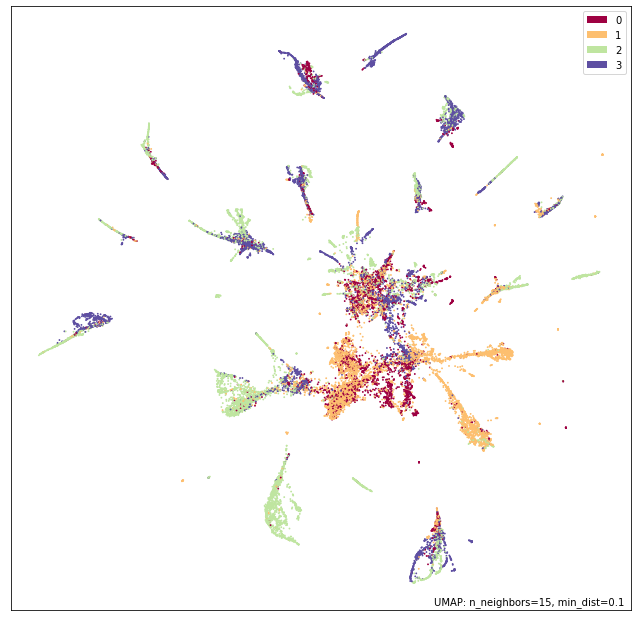

<IPython.core.display.Javascript object>

In [172]:
import umap.plot

umap.plot.points(mapper, labels=data_all.y.cpu().numpy())